In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [28]:
df = pd.read_csv('HME020030N.csv', parse_dates=[0])
# remove 0 data from tags positions

tags_columns_list = list(df)[64:114]
overall_max = 0
for col in tags_columns_list:
    current_max = df.loc[:, col].max()
    overall_max = current_max if current_max > overall_max else overall_max

# replace all zeros with overall_max
for col in tags_columns_list:
    df.loc[:, col] = df.loc[:, col].map(lambda x: x if x != 0 else overall_max)
    
# replace fractional numbers(aggregated from the wrong data) by NaN
for col in  tags_columns_list:
    df.loc[:, col] = df.loc[:, col].map(lambda x: x if x == np.int(x) else np.nan)
    
df.dropna(subset=['target'], inplace=True)

for freq in ['1M', '1Q', '1Y']:
    df.fillna(df.groupby(pd.Grouper(key='Unnamed: 0', freq=freq)).transform('mean'), inplace=True)  

In [29]:
df.columns = ['ds'] + list(df)[1:-1] + ['y']

In [30]:
df.head(7)

,ds,dehumidifier 50 pint_ara,dehumidifier 50 pint_trend,dehumidifier_ara,dehumidifier_trend,dehumidifiers for home_ara,dehumidifiers for home_trend,dehumidifier 30 pint_ara,dehumidifier 30 pint_trend,dehumidifiers_ara,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,y
0,2017-07-11,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,11,1,192,0,0,0,0,0,0,45.0
1,2017-07-12,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,12,2,193,0,0,0,0,0,0,58.0
2,2017-07-13,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,13,3,194,0,0,0,0,0,0,28.0
3,2017-07-14,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14,4,195,0,0,0,0,0,0,31.0
4,2017-07-15,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,15,5,196,0,0,0,0,0,0,37.0
5,2017-07-16,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,16,6,197,0,0,0,0,0,0,48.0
6,2017-07-17,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,17,0,198,0,0,0,0,0,0,50.0


In [31]:
df.drop(columns=list(df)[list(df).index('Year'):list(df).index('y')], inplace=True)

In [32]:
df = df.resample('1W', on='ds').mean()

In [33]:
df.reset_index(inplace=True)
df.head()

,ds,dehumidifier 50 pint_ara,dehumidifier 50 pint_trend,dehumidifier_ara,dehumidifier_trend,dehumidifiers for home_ara,dehumidifiers for home_trend,dehumidifier 30 pint_ara,dehumidifier 30 pint_trend,dehumidifiers_ara,...,dehumidifier auto shut off,dehumidifier for rv,dehumidifier with hose,dehumidifier with hose drain,crawl space dehumidifier,dehumidifier hose,dehumidifier energy star,small dehumidifier for bathroom,dehumidifier 70,y
0,2017-07-16,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,41.166667
1,2017-07-23,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,58.857143
2,2017-07-30,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,58.571429
3,2017-08-06,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,77.571429
4,2017-08-13,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,...,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,120.142857


In [38]:
def create_prophet(df):
    pr = Prophet()
    pr.add_country_holidays(country_name='US')
#     for col in list(df)[1:-1]:
#         pr.add_regressor(col)
    return pr

In [39]:
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)
score = 0
for train_index, val_index in tscv.split(df):
    df_train = df.iloc[train_index]
    X_val, y_val = df.iloc[val_index, :-1], df.iloc[val_index, -1]
    pr = create_prophet(df_train)
    pr.fit(df_train)
    forecast = pr.predict(X_val)
    cur_score = mean_squared_error(y_val, forecast.yhat)
    print(cur_score)
    score += cur_score
score /= n_splits
score

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 9.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.


394.4174924891275


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


947.6957663991808


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1043.2818912815792


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6417.495014616649


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6439.310834370285


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6828.942237695496


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10084.686949001354


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5944.776713840257


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1073.5727945459887
2959.4371188387113


4213.361681307862

In [15]:
future = pr.make_future_dataframe(periods=10, freq='1W')
forecast = pr.predict(future)

ValueError: Regressor "dehumidifier 50 pint_ara" missing from dataframe

In [24]:
forecast = pr.predict(df)

In [26]:
df.tail()

,ds,dehumidifier 50 pint_ara,dehumidifier 50 pint_trend,dehumidifier_ara,dehumidifier_trend,dehumidifiers for home_ara,dehumidifiers for home_trend,dehumidifier 30 pint_ara,dehumidifier 30 pint_trend,dehumidifiers_ara,...,dehumidifier auto shut off,dehumidifier for rv,dehumidifier with hose,dehumidifier with hose drain,crawl space dehumidifier,dehumidifier hose,dehumidifier energy star,small dehumidifier for bathroom,dehumidifier 70,y
98,2019-06-02,1276548.0,410.15,1949.5,526.325,55899.0,219.375,806884.0,421.35,79735.0,...,350.0,121.180328,350.0,350.0,350.0,350.0,350.0,0.0,0.0,935.0
99,2019-06-09,1380078.0,396.20,2117.5,527.975,53445.0,212.625,794206.0,405.30,78526.0,...,350.0,144.131148,350.0,350.0,350.0,350.0,350.0,0.0,0.0,630.0
100,2019-06-16,1380078.0,396.20,2117.5,527.975,53445.0,212.625,794206.0,405.30,78526.0,...,350.0,144.131148,350.0,350.0,350.0,350.0,350.0,0.0,0.0,684.0
101,2019-06-23,1380078.0,396.20,2117.5,527.975,53445.0,212.625,794206.0,405.30,78526.0,...,350.0,144.131148,350.0,350.0,350.0,350.0,350.0,0.0,0.0,1391.0
102,2019-06-30,197154.0,56.60,302.5,75.425,7635.0,30.375,113458.0,57.90,11218.0,...,50.0,20.590164,50.0,50.0,50.0,50.0,50.0,0.0,0.0,57.0


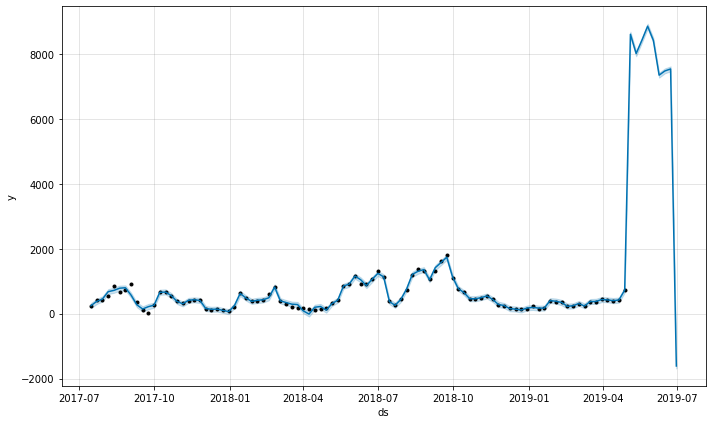

In [25]:
fig1 = pr.plot(forecast)

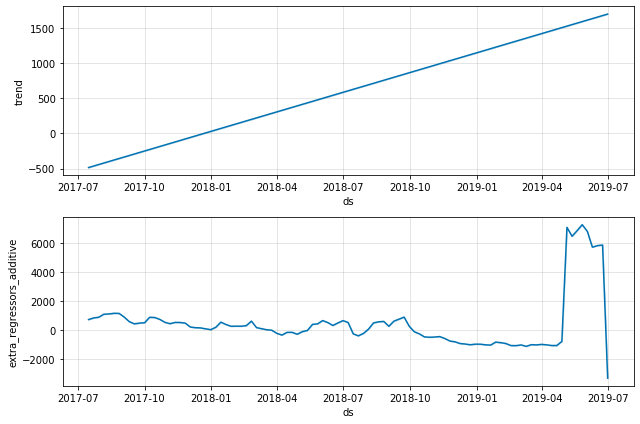

In [19]:
fig2 = pr.plot_components(forecast)